# German TTS with VoxPopuli and Audio Transformers

In [ ]:
%pip install transformers "datasets==3.6.0" soundfile speechbrain accelerate wandb


In [ ]:
from huggingface_hub import notebook_login, login
from google.colab import userdata
import wandb

from datasets import load_dataset, Audio
from collections import defaultdict
import matplotlib.pyplot as plt
import os
import torch
from speechbrain.pretrained import EncoderClassifier
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import matplotlib.pyplot as plt

from IPython.display import Audio
from functools import partial
from transformers import SpeechT5Processor
from transformers import SpeechT5ForTextToSpeech
from transformers import Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer
from transformers import SpeechT5ForTextToSpeech
from transformers import SpeechT5HifiGan


In [ ]:
!nvidia-smi

Sun Oct 12 18:58:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
HF_TOKEN = os.getenv('HF_TOKEN')
WANDB_API_KEY= os.getenv('WANDB_API_KEY')
LANGUAGE = "de"

if WANDB_API_KEY is None or HF_TOKEN is None:
  print("Please set the HF_TOKEN and WANDB_API_KEY environment variables.")
  

os.environ["WANDB_PROJECT"]="TTS-voxpopuli"

wandb.login(key=WANDB_API_KEY)
login(HF_TOKEN)

In [ ]:
dataset = load_dataset("facebook/voxpopuli", LANGUAGE, split="train", trust_remote_code=True)
len(dataset)

108473

In [ ]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

In [ ]:
tokenizer = processor.tokenizer

In [ ]:
dataset[0]

{'audio_id': '20120315-0900-PLENARY-14-de_20120315-16:29:53_3',
 'language': 1,
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/087d32c0853da45d490e18b778ac2507443b8b6dcd66c27208cd9d4431980304/train_part_0/20120315-0900-PLENARY-14-de_20120315-16:29:53_3.wav',
  'array': array([-0.1496582 , -0.14880371, -0.12649536, ..., -0.00421143,
          0.01269531,  0.03085327]),
  'sampling_rate': 16000},
 'raw_text': 'Natürlich gibt es Übergriffe des Herrscherhauses und des Sicherheitsapparates und der Saudis, die sich dahinter verstecken und die gerne Bahrain in ihren Staat integrieren würden.',
 'normalized_text': 'natürlich gibt es übergriffe des herrscherhauses und des sicherheitsapparates und der saudis die sich dahinter verstecken und die gerne bahrain in ihren staat integrieren würden.',
 'gender': 'male',
 'speaker_id': '2229',
 'is_gold_transcript': True,
 'accent': 'None'}

In [ ]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/108473 [00:00<?, ? examples/s]

In [ ]:
dataset_vocab - tokenizer_vocab

{' ', '1', 'ß', 'ä', 'ö', 'ü'}

The vocabulary of a language might not be in the tokenizer of a TTS model. In this notebook we will use the [VoxPopuli](https://huggingface.co/datasets/facebook/voxpopuli) dataset to finetune a TTS model for German. Therefore one must find replacements of tokens that are not in the tokenizer.

In [ ]:
replacements = [
    ("ß", "ss"),
    ("ä", "ae"),
    ("ö", "oe"),
    ("ü", "ue"),
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs


dataset = dataset.map(cleanup_text)

Map:   0%|          | 0/108473 [00:00<?, ? examples/s]

In [ ]:
speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

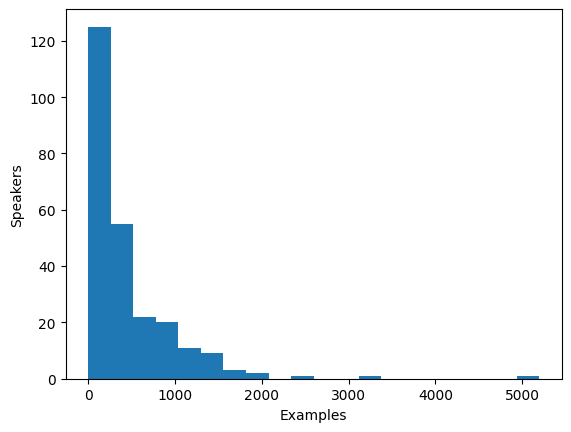

In [ ]:


plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [ ]:
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400


dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

Filter:   0%|          | 0/108473 [00:00<?, ? examples/s]

In [ ]:
len(set(dataset["speaker_id"]))

81

In [ ]:
len(dataset)

20081

In [ ]:
spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/tmp/speechbrain/spkrec-xvect-voxceleb/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in /tmp/speechbrain/spkrec-xvect-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/tmp/speechbrain/spkrec-xvect-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /tmp/speechbrain/spkrec-xvect-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/tmp/speechbrain/spkrec-xvect-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /tmp/speechbrain/spkrec-xvect-voxceleb/mean_var_norm_emb.ck

In [ ]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

In [ ]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [ ]:
processed_example["speaker_embeddings"].shape

(512,)

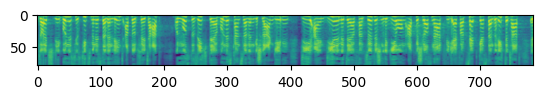

In [ ]:

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [ ]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

Map:   0%|          | 0/20081 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (889 > 600). Running this sequence through the model will result in indexing errors


In [ ]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200


dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

Filter:   0%|          | 0/20081 [00:00<?, ? examples/s]

15586

In [ ]:
dataset = dataset.train_test_split(test_size=0.1)

In [ ]:


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [ ]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [ ]:

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

In [ ]:


# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [ ]:


training_args = Seq2SeqTrainingArguments(
    output_dir=f"speecht5_finetuned_voxpopuli_{LANGUAGE}",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=40_000,
    gradient_checkpointing=True,
    # This is important to fix the backward error
    gradient_checkpointing_kwargs={"use_reentrant": False},
    fp16=True,
    eval_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard", "wandb"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

In [ ]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

/tmp/ipython-input-1231872571.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
1000,0.527100,0.484735
2000,0.505300,0.471582
3000,0.505100,0.466454
4000,0.502200,0.463496


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3922: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1876}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=4000, training_loss=0.5300946877002716, metrics={'train_runtime': 7885.5277, 'train_samples_per_second': 16.232, 'train_steps_per_second': 0.507, 'total_flos': 1.7332998434463888e+16, 'train_loss': 0.5300946877002716, 'epoch': 9.111776447105788})

In [ ]:
trainer.push_to_hub()

In [ ]:

model = SpeechT5ForTextToSpeech.from_pretrained(
    f"SverreNystad/speecht5_finetuned_voxpopuli_{LANGUAGE}"
)

In [ ]:
example = dataset["test"][1]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)

In [ ]:
text = "Ich bin ein Berliner! Meine Name bin Sverre Nystad. Ich libe Deutch!"

In [ ]:
inputs = processor(text=text, return_tensors="pt")

In [ ]:

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

In [ ]:
Audio(speech.numpy(), rate=16000)